### 1

In [22]:
%matplotlib inline

In [115]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import normalize as norm
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score, f1_score, classification_report, roc_curve, log_loss

RAND = 42

In [24]:
data = pd.read_csv('Data\card_transdata.csv\card_transdata.csv')
data.head(5)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


distance_from_home -  расстояние от дома, где произошла транзакция.

distance_from_last_transaction - расстояние от последней транзакции.

ratio_to_median_purchase_price - Отношение цены покупки к медианной цене покупки.

repeat_retailer - транзакция произошла от одного и того же продавца.

used_chip - это транзакция через чип (кредитную карту).

used_pin_number - произошла ли транзакция с использованием пин-кода.

online_order - является ли транзакция онлайн-заказом.

fraud - Является ли транзакция мошеннической.


## 2

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [27]:
data.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


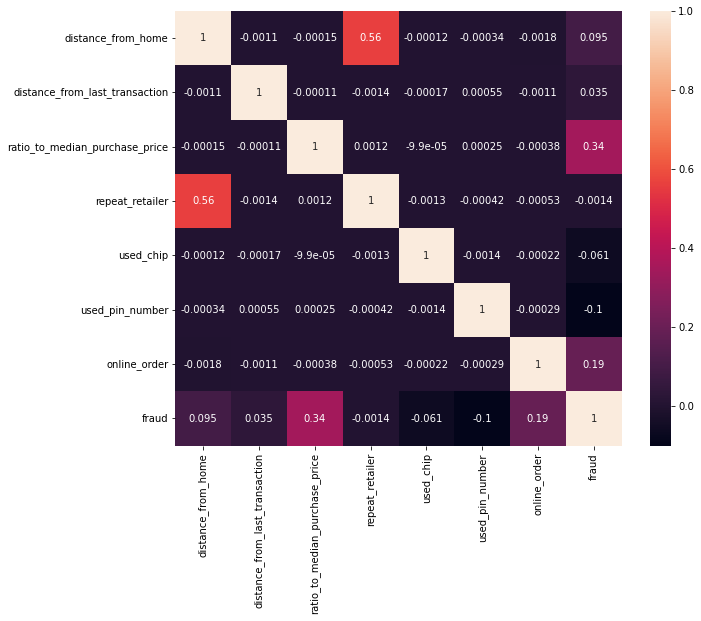

In [28]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr('spearman'), annot=True)
plt.show()

## 3

##### Гипотезы: 
* средний ratio_to_median_purchase_price больше у мошеннических транзакций
* при online_order транзакциях шанс что это мошенничество больше
* при online_order транзакциях средний ratio_to_median_purchase_price больше
* distance_from_home в среднем выше у мошенническиз транзакций
* distance_from_last_transaction в среднем выше у мошеннических транзакций
* если used_pin_number = 1.0, то вероятность что это мошенничество меньше

##### 3.1) Target

Text(1, 10, '8%')

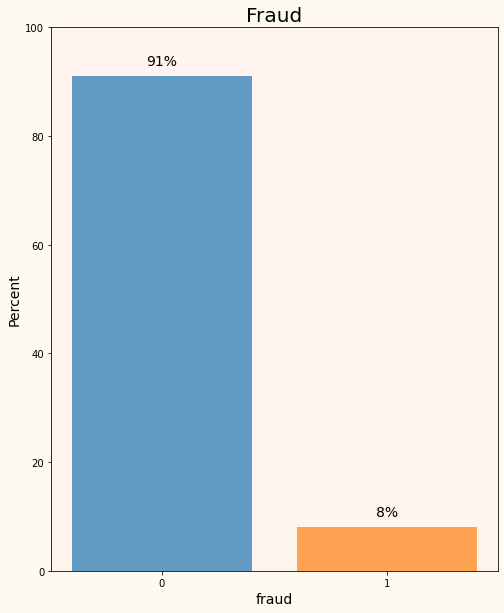

In [29]:
norm_target = data.fraud.value_counts()
norm_target_shape = data.fraud.shape[0]
for i in norm_target.index:
    norm_target[i] = (norm_target[i] / norm_target_shape) * 100

fig, axes = plt.subplots(figsize=(8, 10))

fig.set_facecolor('floralwhite')
axes.set_facecolor('seashell')

axes.set_ylim(0, 100)
axes.set_title('Fraud', fontsize=20)
axes.set_xlabel('fraud', fontsize=14)
axes.set_ylabel('Percent', fontsize=14)

axes.bar('0', height=norm_target[0], alpha = 0.7)
axes.annotate(f'{norm_target[0]}%', xy=(0,0), xytext=(0, norm_target[0] + 2), ha='center', fontsize=14)
axes.bar('1', height=norm_target[1], alpha = 0.7)
axes.annotate(f'{norm_target[1]}%', xy=(0,0), xytext=(1, norm_target[1] + 2), ha='center', fontsize=14)

Присутствует дисболанс классов, это стоит учитывать при обучении модели

##### 3.2) ratio_to_median_purchase_price

Text(2, 1.9241819784044585, '1.82')

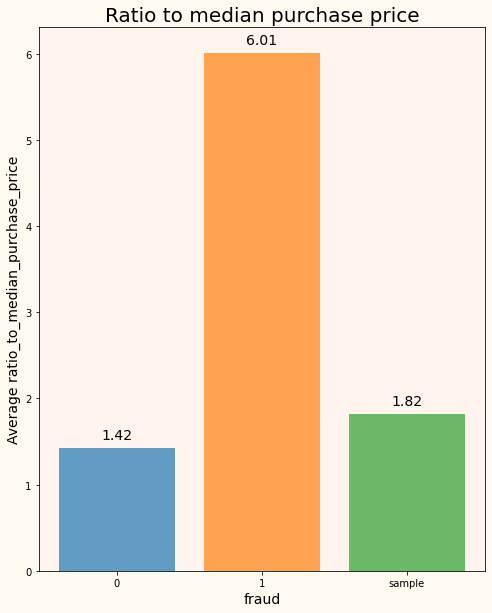

In [38]:
x_0 = data[data.fraud == 0].ratio_to_median_purchase_price.mean()
x_1 = data[data.fraud == 1].ratio_to_median_purchase_price.mean()
x_2 = data.ratio_to_median_purchase_price.mean()

fig, axes = plt.subplots(figsize=(8, 10))

fig.set_facecolor('floralwhite')
axes.set_facecolor('seashell')

axes.set_title('Ratio to median purchase price', fontsize=20)
axes.set_xlabel('fraud', fontsize=14)
axes.set_ylabel('Average ratio_to_median_purchase_price', fontsize=14)

axes.bar('0', height=x_0, alpha = 0.7)
axes.annotate('{:.2f}'.format(x_0), xy=(0,0), xytext=(0, x_0 + 0.1), ha='center', fontsize=14)
axes.bar('1', height=x_1, alpha = 0.7)
axes.annotate('{:.2f}'.format(x_1), xy=(0,0), xytext=(1, x_1 + 0.1), ha='center', fontsize=14)
axes.bar('sample', height=x_2, alpha = 0.7)
axes.annotate('{:.2f}'.format(x_2), xy=(0,0), xytext=(2, x_2 + 0.1), ha='center', fontsize=14)

Text(2, 1.097716936873089, '1.00')

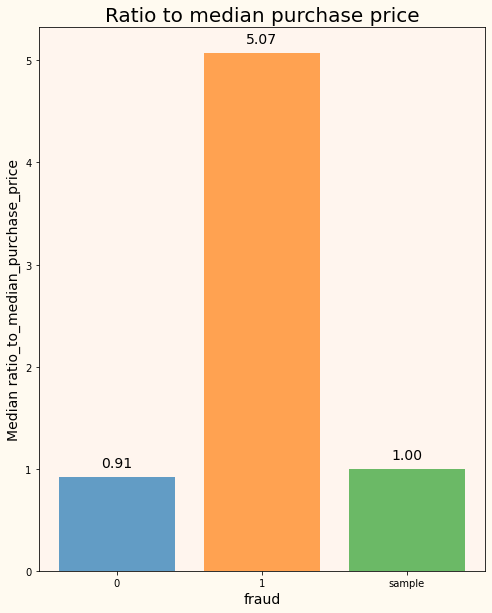

In [39]:
x_0 = data[data.fraud == 0].ratio_to_median_purchase_price.median()
x_1 = data[data.fraud == 1].ratio_to_median_purchase_price.median()
x_2 = data.ratio_to_median_purchase_price.median()

fig, axes = plt.subplots(figsize=(8, 10))

fig.set_facecolor('floralwhite')
axes.set_facecolor('seashell')

axes.set_title('Ratio to median purchase price', fontsize=20)
axes.set_xlabel('fraud', fontsize=14)
axes.set_ylabel('Median ratio_to_median_purchase_price', fontsize=14)

axes.bar('0', height=x_0, alpha = 0.7)
axes.annotate('{:.2f}'.format(x_0), xy=(0,0), xytext=(0, x_0 + 0.1), ha='center', fontsize=14)
axes.bar('1', height=x_1, alpha = 0.7)
axes.annotate('{:.2f}'.format(x_1), xy=(0,0), xytext=(1, x_1 + 0.1), ha='center', fontsize=14)
axes.bar('sample', height=x_2, alpha = 0.7)
axes.annotate('{:.2f}'.format(x_2), xy=(0,0), xytext=(2, x_2 + 0.1), ha='center', fontsize=14)

([<matplotlib.axis.XTick at 0x237009f2430>,
 [Text(1, 0, '0'), Text(2, 0, '1')])

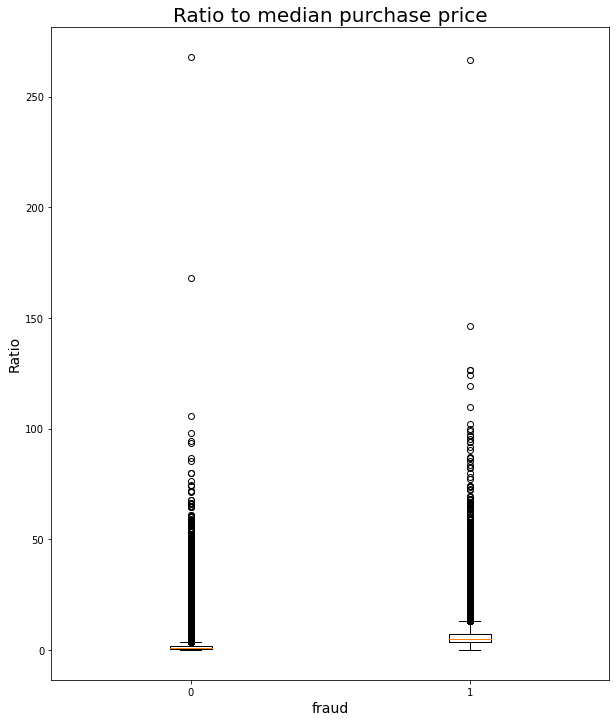

In [40]:
fig, axes = plt.subplots(figsize=(10, 12))

axes.set_title('Ratio to median purchase price', fontsize=20)
axes.set_xlabel('fraud', fontsize=14)
axes.set_ylabel('Ratio', fontsize=14)

x = data[['fraud', 'ratio_to_median_purchase_price']]

x_0 = x[x.fraud == 0].ratio_to_median_purchase_price
x_1 = x[x.fraud == 1].ratio_to_median_purchase_price
x = [x_0, x_1]

axes.boxplot(x)
plt.xticks([1, 2], ['0', '1'])

Как можно видеть на графиках среднее и медиана у Ratio to median purchase price больше у мошеннических транзакций

##### 3.3) online_order

Text(0, 0.5, 'number of records')

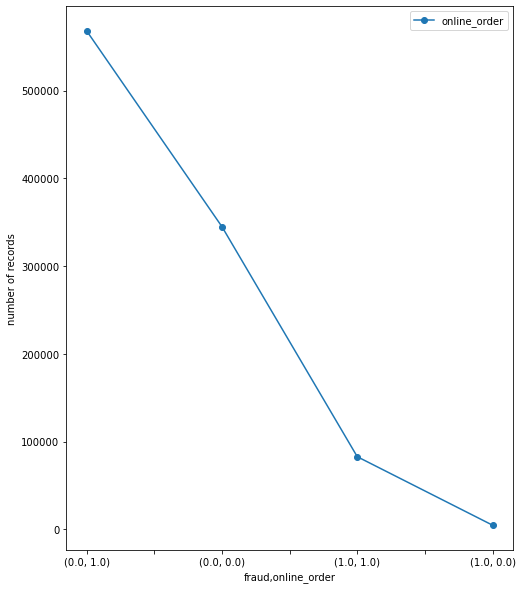

In [63]:
fig, axes = plt.subplots(figsize=(8, 10))

data.groupby('fraud')['online_order'].value_counts().plot(legend=True,marker='o',ax=axes)
plt.ylabel("number of records")

В выборке большая часть мошеннических транзакций происходит в онлайне

C:\Users\sirod\AppData\Local\Temp/ipykernel_6364/2603054247.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  height=x[x['fraud'] == x_0][x['online_order'] == x_1]['ratio_to_median_purchase_price'].mean()


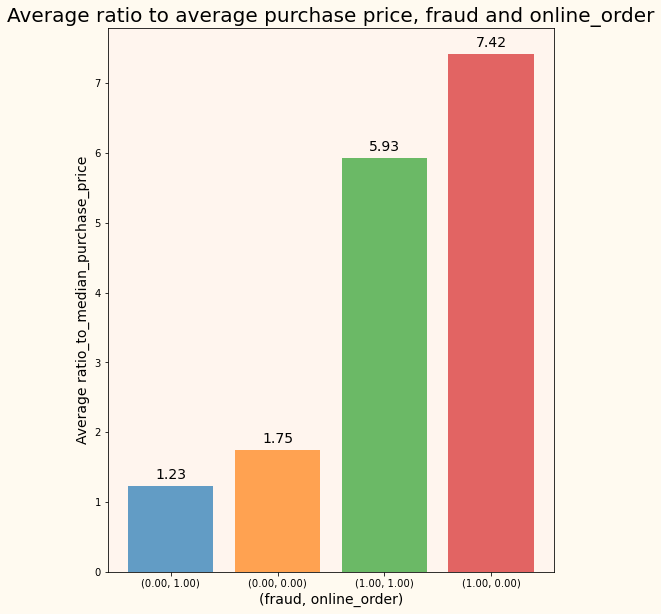

In [41]:
fig, axes = plt.subplots(figsize=(8, 10))

axes.set_title('Average ratio to average purchase price, fraud and online_order', fontsize=20)
axes.set_xlabel('(fraud, online_order)', fontsize=14)
axes.set_ylabel('Average ratio_to_median_purchase_price', fontsize=14)
i=0
x = data[['fraud', 'ratio_to_median_purchase_price', 'online_order']]

fig.set_facecolor('floralwhite')
axes.set_facecolor('seashell')

for x_0 in x['fraud'].value_counts().index:
    for x_1 in x['online_order'].value_counts().index:

        height=x[x['fraud'] == x_0][x['online_order'] == x_1]['ratio_to_median_purchase_price'].mean()

        axes.bar('({0:.2f}, {1:.2f})'.format(x_0, x_1), height=height, alpha = 0.7)
        axes.annotate('{:.2f}'.format(height), xy=(0,0), xytext=(i, axes.patches[i].get_height() + 0.1), ha='center', fontsize=14)
        i = i + 1
        

##### 3.3) distance_from_home

C:\Users\sirod\AppData\Local\Temp/ipykernel_6364/54275503.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  height=x[x['fraud'] == x_0][x['online_order'] == x_1]['distance_from_home'].mean()


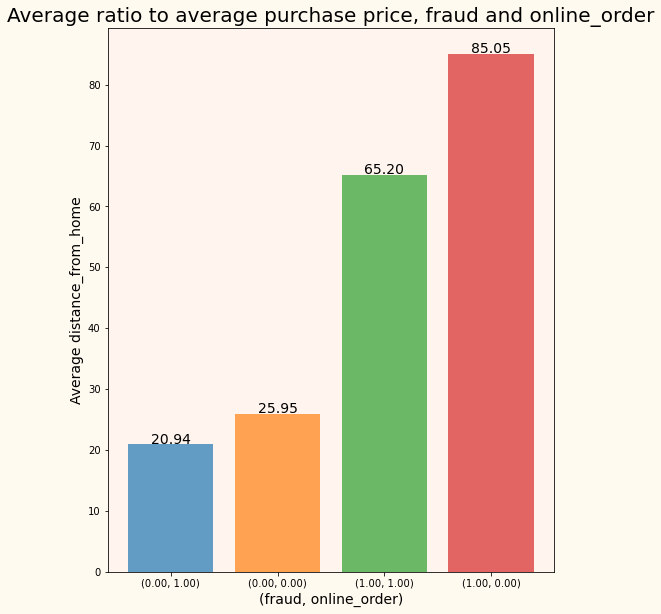

In [42]:
fig, axes = plt.subplots(figsize=(8, 10))

axes.set_title('Average ratio to average purchase price, fraud and online_order', fontsize=20)
axes.set_xlabel('(fraud, online_order)', fontsize=14)
axes.set_ylabel('Average distance_from_home', fontsize=14)
i=0
x = data[['fraud', 'distance_from_home', 'online_order']]

fig.set_facecolor('floralwhite')
axes.set_facecolor('seashell')

for x_0 in x['fraud'].value_counts().index:
    for x_1 in x['online_order'].value_counts().index:

        height=x[x['fraud'] == x_0][x['online_order'] == x_1]['distance_from_home'].mean()

        axes.bar('({0:.2f}, {1:.2f})'.format(x_0, x_1), height=height, alpha = 0.7)
        axes.annotate('{:.2f}'.format(height), xy=(0,0), xytext=(i, axes.patches[i].get_height() + 0.1), ha='center', fontsize=14)
        i = i + 1

C:\Users\sirod\AppData\Local\Temp/ipykernel_6364/563826785.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  height=x[x['fraud'] == x_0][x['online_order'] == x_1]['distance_from_home'].median()


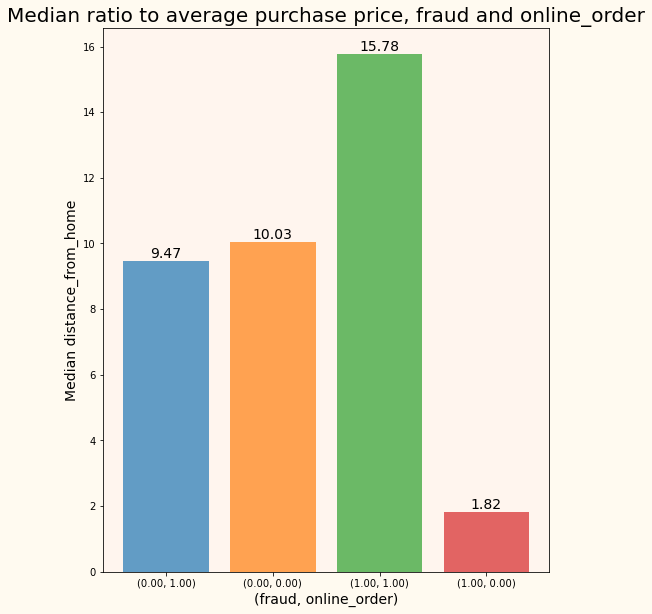

In [68]:
fig, axes = plt.subplots(figsize=(8, 10))

axes.set_title('Median ratio to average purchase price, fraud and online_order', fontsize=20)
axes.set_xlabel('(fraud, online_order)', fontsize=14)
axes.set_ylabel('Median distance_from_home', fontsize=14)
i=0
x = data[['fraud', 'distance_from_home', 'online_order']]

fig.set_facecolor('floralwhite')
axes.set_facecolor('seashell')

for x_0 in x['fraud'].value_counts().index:
    for x_1 in x['online_order'].value_counts().index:

        height=x[x['fraud'] == x_0][x['online_order'] == x_1]['distance_from_home'].median()

        axes.bar('({0:.2f}, {1:.2f})'.format(x_0, x_1), height=height, alpha = 0.7)
        axes.annotate('{:.2f}'.format(height), xy=(0,0), xytext=(i, axes.patches[i].get_height() + 0.1), ha='center', fontsize=14)
        i = i + 1

##### 3.4) distance_from_last_transaction

C:\Users\sirod\AppData\Local\Temp/ipykernel_6364/2851989274.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  height=x[x['fraud'] == x_0][x['online_order'] == x_1]['distance_from_last_transaction'].mean()


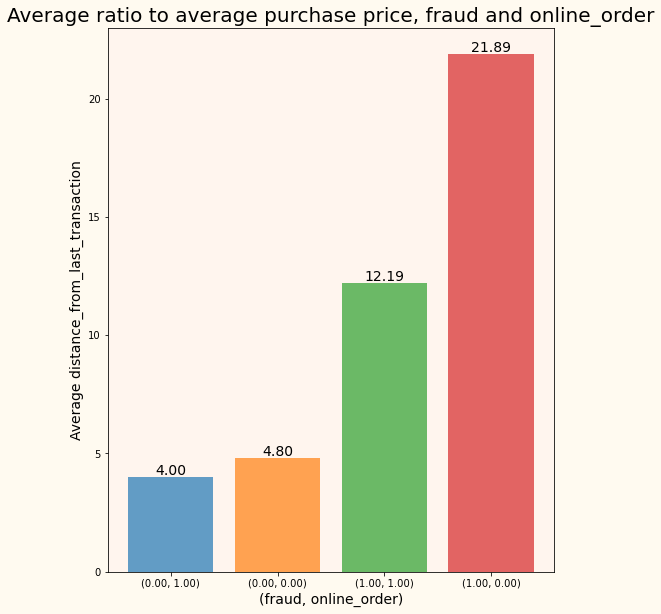

In [45]:
fig, axes = plt.subplots(figsize=(8, 10))

axes.set_title('Average ratio to average purchase price, fraud and online_order', fontsize=20)
axes.set_xlabel('(fraud, online_order)', fontsize=14)
axes.set_ylabel('Average distance_from_last_transaction', fontsize=14)
i=0
x = data[['fraud', 'distance_from_last_transaction', 'online_order']]

fig.set_facecolor('floralwhite')
axes.set_facecolor('seashell')

for x_0 in x['fraud'].value_counts().index:
    for x_1 in x['online_order'].value_counts().index:

        height=x[x['fraud'] == x_0][x['online_order'] == x_1]['distance_from_last_transaction'].mean()

        axes.bar('({0:.2f}, {1:.2f})'.format(x_0, x_1), height=height, alpha = 0.7)
        axes.annotate('{:.2f}'.format(height), xy=(0,0), xytext=(i, axes.patches[i].get_height() + 0.1), ha='center', fontsize=14)
        i = i + 1

C:\Users\sirod\AppData\Local\Temp/ipykernel_6364/3548428670.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  height=x[x['fraud'] == x_0][x['online_order'] == x_1]['distance_from_last_transaction'].median()


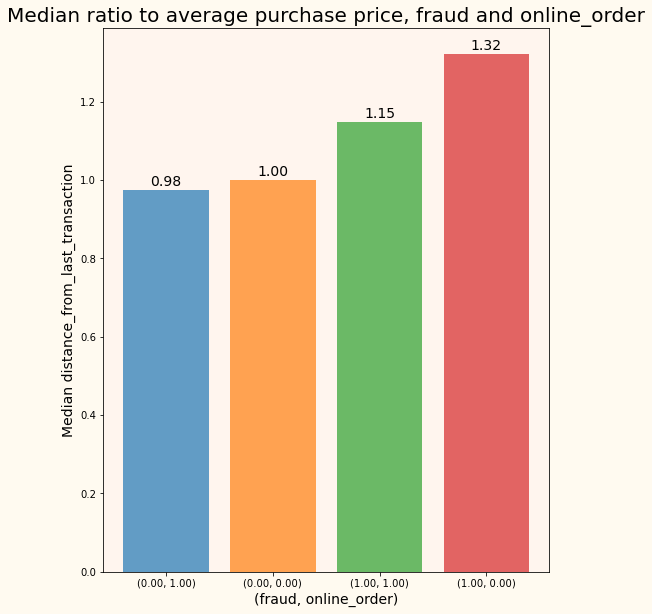

In [57]:
fig, axes = plt.subplots(figsize=(8, 10))

axes.set_title('Median ratio to average purchase price, fraud and online_order', fontsize=20)
axes.set_xlabel('(fraud, online_order)', fontsize=14)
axes.set_ylabel('Median distance_from_last_transaction', fontsize=14)
i=0
x = data[['fraud', 'distance_from_last_transaction', 'online_order']]

fig.set_facecolor('floralwhite')
axes.set_facecolor('seashell')

for x_0 in x['fraud'].value_counts().index:
    for x_1 in x['online_order'].value_counts().index:

        height=x[x['fraud'] == x_0][x['online_order'] == x_1]['distance_from_last_transaction'].median()

        axes.bar('({0:.2f}, {1:.2f})'.format(x_0, x_1), height=height, alpha = 0.7)
        axes.annotate('{:.2f}'.format(height), xy=(0,0), xytext=(i, axes.patches[i].get_height() + 0.01), ha='center', fontsize=14)
        i = i + 1

##### 3.5) used_pin_number

Text(0, 0.5, 'number of records')

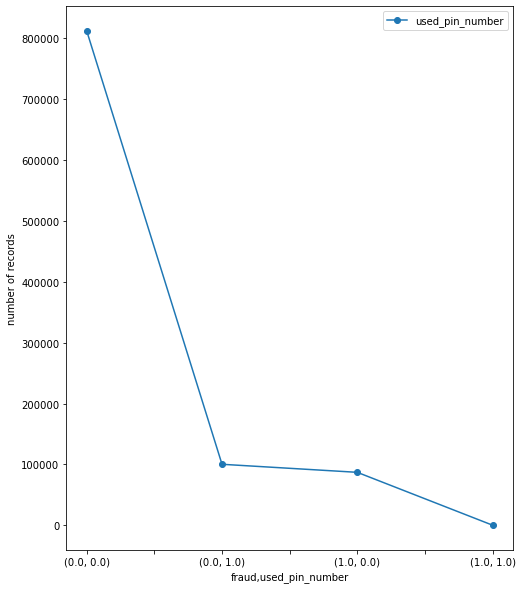

In [70]:
fig, axes = plt.subplots(figsize=(8, 10))

data.groupby('fraud')['used_pin_number'].value_counts().plot(legend=True,marker='o',ax=axes)
plt.ylabel("number of records")

Text(0, 0.5, 'number of records')

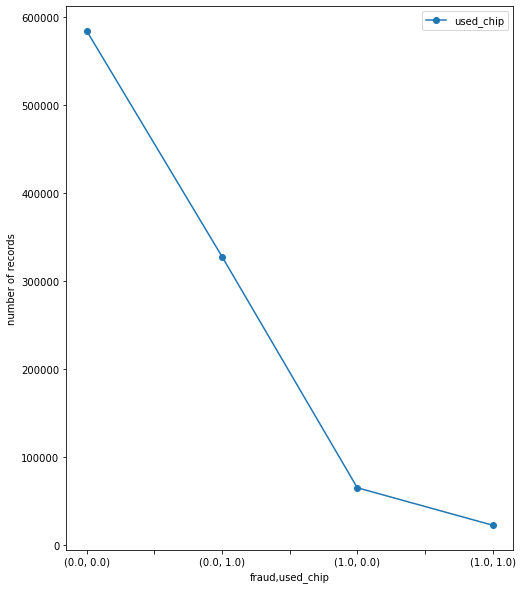

In [71]:
fig, axes = plt.subplots(figsize=(8, 10))

data.groupby('fraud')['used_chip'].value_counts().plot(legend=True,marker='o',ax=axes)
plt.ylabel("number of records")

## 4) Моделирование

In [72]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RAND)
for train_index, test_index in split.split(data, data['fraud']):
    train_data_split = data.loc[train_index]
    test_data_split = data.loc[test_index]

In [74]:
X = data.drop('fraud', axis=1)
y = data['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, shuffle=True, random_state=RAND)

In [119]:
def print_metrics(y_train, y_pred, y_score):
    print(f'precision {precision_score(np.array(y_train), y_pred)}')
    print(f'recall {recall_score(np.array(y_train), y_pred)}')
    print(f'f1_score {f1_score(np.array(y_train), y_pred)}')
    print(f'roc_auc_score {roc_auc_score(np.array(y_train), y_score)}')
    print(f'log_loss {log_loss(np.array(y_train), y_pred)}')

##### 4.1) 

In [92]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)


c:\Users\sirod\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [120]:
y_pred_lr =  lr.predict(X_train)
y_score_lr = lr.predict_proba(X_train)[:,1]

print_metrics(np.array(y_train), y_pred_lr, y_score_lr)

precision 0.5685296441235371
recall 0.9441206980717598
f1_score 0.709695544980219
roc_auc_score 0.9783675976507687
log_loss 2.3317398436250896


In [133]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'log', class_weight='balanced', random_state=RAND)
sgd_clf.fit(X_train, y_train)

In [136]:
y_pred_sgd_clf = sgd_clf.predict(X_train)
y_score_sgd_clf = sgd_clf.predict_proba(X_train)[:,1]

print_metrics(np.array(y_train), y_pred_sgd_clf, y_score_sgd_clf)

precision 0.6121236425804953
recall 0.8848395167195509
f1_score 0.723639970307344
roc_auc_score 0.9646012883090413
log_loss 2.040267732036903
